In [1]:
import sys
import numpy as np
import math
import ceo
%pylab inline
%run GMT-DOS-Estimation-SAO.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
nPx = N_PX_LENLSET*N_LENSLET+1
print "pupil sampling:      %d pixel"%nPx
detectorRes = 2.0*N_PX_LENLSET*N_LENSLET/2.0
print "detector resolution: %d pixel"%detectorRes
zenith_angle  = np.ones((1,N_GS))*zenith_distance_arcmin*ceo.constants.ARCMIN2RAD # in radians
azimuth_angle = np.arange(N_GS)*360.0/N_GS # in degrees
gs    = ceo.Source(AGWS_photometric_band,
                   zenith=zenith_angle,azimuth=azimuth_angle*math.pi/180,
                   rays_box_size=entrance_pupil_size_meter,
                   rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
wfs = ceo.ShackHartmann(N_LENSLET, N_PX_LENLSET, lenslet_pitch_meter, 
                        N_PX_IMAGE=N_PX_LENLSET,BIN_IMAGE=2,N_GS=N_GS)
gmt = ceo.GMT_MX(entrance_pupil_size_meter,nPx,M1_radial_order=M1_zernike_radial_order)

pupil sampling:      937 pixel
detector resolution: 936 pixel


In [3]:
gs.wavelength*ceo.constants.RAD2ARCSEC/2

0.06600473759792895

In [4]:
from scipy.optimize import brentq
def ee80(_psf_,_px_scale_):
    n,m = _psf_.shape
    u = np.linspace(-1,1,n)*(n/2)
    v = np.linspace(-1,1,m)*(m/2)
    x,y = np.meshgrid(u,v)
    def ee80_fun(ee_Delta):
        _ee_Delta_ = (ee_Delta-1)/2
        gate = np.logical_and(np.abs(x)<=_ee_Delta_,np.abs(y)<=_ee_Delta_)
        return np.sum(psf*gate)/(src.nPhoton*368) - 0.8
    try:
        q = brentq(ee80_fun,1,81)*_px_scale_*ceo.constants.RAD2MAS
    except ValueError:
        q = np.float('inf')
    return q

pixel size: 1.27mas


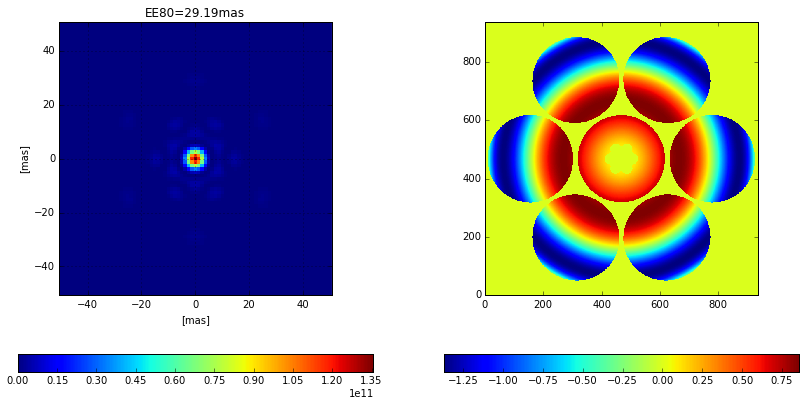

In [5]:
src = ceo.Source(S_photometric_band,
                 rays_box_size=entrance_pupil_size_meter,
                 rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt.reset()
gmt.propagate(src)
imgr = ceo.Imaging(1, nPx-1,DFT_osf=2*nyquist_oversampling_factor,
                   N_PX_IMAGE=detector_resolution,N_SOURCE=src.N_SRC)
imgr.propagate(src)
fig, (ax1,ax2) = subplots(nrows=1,ncols=2)
fig.set_size_inches((14,7))
psf = imgr.frame.host()
px_scale = src.wavelength/(entrance_pupil_size_meter*4)
h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
ee80_0 = ee80(psf,px_scale)
ax1.set_title("EE80=%.2fmas"%ee80_0)
colorbar(h1,ax=ax1,orientation='horizontal')
h2 = ax2.imshow(src.wavefront.phase.host(shape=(nPx*src.N_SRC,nPx),units='nm').T,interpolation='none',origin='lower')
colorbar(h2,ax=ax2,orientation='horizontal')
print "pixel size: %.2fmas"%(px_scale*ceo.constants.RAD2MAS)

#Calibrations
## Wavefront sensors

[ 1278.32055664  1278.44360352  1278.41247559]


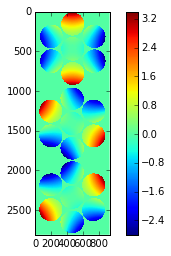

In [6]:
#gmt.M1.update(origin=[0e-6,0.0,0.0],idx=1)
#gs.reset()
gmt.reset()
gs.reset()
gmt.propagate(gs)
ps0 = gs.phase.host(units='micron')
imshow(ps0,interpolation='None')
colorbar()
print gs.wavefront.rms()*1e9
wfs.calibrate(gs,0.8)

In [8]:
print wfs.frame.shape
print "Pixel size: %.3farcsec"%(wfs.BIN_IMAGE*wfs.pixel_scale_arcsec)
print "Field of view: %.3farcsec"%(wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/2)

(1404, 468)
Pixel size: 0.264arcsec
Field of view: 2.376arcsec


12000.4795761
12000.4795761
10393.9299082
12419.1474975


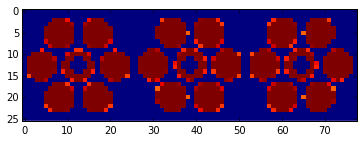

In [9]:
imshow(wfs.flux.host().T,interpolation='none')
print src.nPhoton*1e-9*368*3
print gs.nPhoton*1e-9*368
wfs.analyze(gs)
print wfs.flux.host().sum()*1e-9
print wfs.frame.host().sum()*1e-9

## M2 tip-tilt

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------
M2 tip-tilt interaction matrix condition #:   1.10


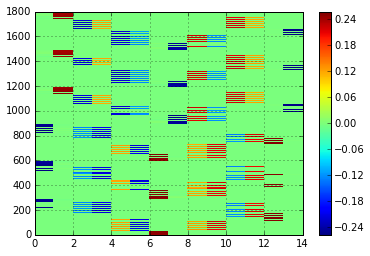

In [10]:
D2tt = gmt.calibrate(wfs,gs,mirror="M2",mode="segment tip-tilt",stroke=200*ceo.constants.MAS2RAD)
fig, ax = subplots()
h = ax.pcolor(D2tt)
colorbar(h)
grid()
print "M2 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D2tt)

## M2 x,y,z translations with M2 segment tip-til removed

In [11]:
mic2m = 1e-6
def M2_xyz(xyz,segId):
    gmt.reset()
    gmt.M2.update(origin=xyz,idx=segId)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [12]:
def M2_seg_TT(origin=[0,0,0],originId=0):
    M = np.linalg.pinv(D2tt)
    M2_R = np.zeros((14,1))
    for kStep in range(4):
        M2_R += np.dot(M,wfs.valid_slopes.host().T)
    #    print M2_R/mas2rad
    #    print M2_R.shape
        for k in range(7):
            R = [-M2_R[2*k,0],-M2_R[2*k+1,0],0]
            if originId==(k+1):
                gmt.M2.update(origin=origin,euler_angles=R,idx=k+1)
            else:
                gmt.M2.update(euler_angles=R,idx=k+1)
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
#    imshow(1e3*wfs.c.host(shape=(nLenslet*2,nLenslet),units='arcsec').T,interpolation='none')
#    colorbar()
    return wfs.valid_slopes.host().ravel()

In [13]:
stroke = 10
c_shape = (gs.N_SRC*N_LENSLET*2,N_LENSLET)
cp_x = cm_x = np.zeros(shape=c_shape)
cp_y = cm_y = np.zeros(shape=c_shape)
cp_z = cm_z = np.zeros(shape=c_shape)
ps_x = ps_y = ps_z = np.zeros(shape=gs.phase.shape)
D2xyz_2 = np.zeros((wfs.n_valid_slopes,3*7))
l = -1
sys.stdout.write("Segment #: ")
for k in range(1,8):
    sys.stdout.write("%d "%k)
    xyz = [stroke*mic2m,0,0]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_x = cp_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    
    ps_x = ps_x + mask*(ps - ps0)
    xyz = [-stroke*mic2m,0,0]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_x = cm_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

    xyz = [0,stroke*mic2m,0]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_y = cp_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_y = ps_y + mask*(ps - ps0)
    xyz = [0,-stroke*mic2m,0]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_y = cm_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

    xyz = [0,0,stroke*mic2m]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_z = cp_z + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_z = ps_z + mask*(ps - ps0)
    xyz = [0,0,-stroke*mic2m]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_z = cm_z + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

Segment #: 1 2 3 4 5 6 7 

<matplotlib.colorbar.Colorbar instance at 0x2b4a668bdcb0>

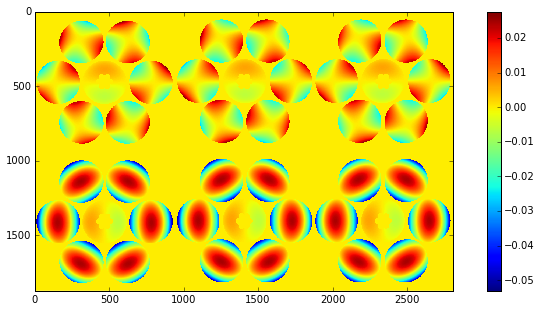

In [14]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
#h2=ax2.imshow(np.concatenate((cp_z,cm_z),axis=1).T,interpolation='none')
h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

<matplotlib.colorbar.Colorbar instance at 0x2b4a66a30680>

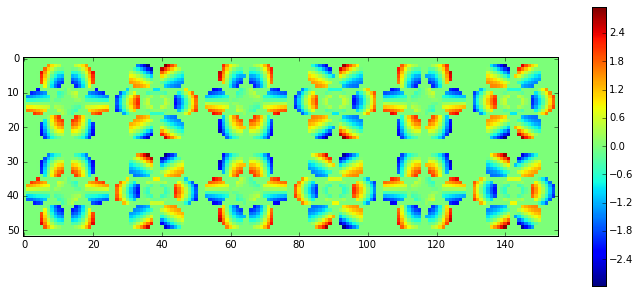

In [15]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
h2=ax2.imshow(np.concatenate((cp_x,cm_x),axis=1).T,interpolation='none')
#h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

M2 x,y,x translation interaction matrix condition #:  41.26


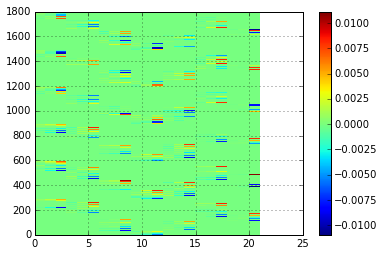

In [16]:
fig, ax = subplots()
h = ax.pcolor(D2xyz_2)
colorbar(h)
grid()
print "M2 x,y,x translation interaction matrix condition #: %6.2f"%np.linalg.cond(D2xyz_2)

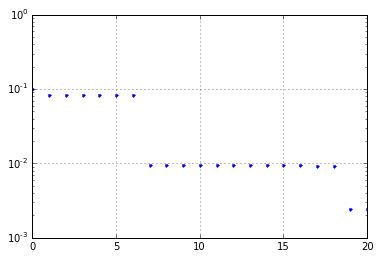

In [17]:
D =  ( D2xyz_2  )
U,S,V = np.linalg.svd(D)
semilogy(S,'.')
grid()

## M1 global tip-tilt with M2 segment tip-til removed

In [18]:
mas2rad = 1e-3*math.pi/180/3600
def M1_global_TT(tip,tilt):
    gmt.reset()
    gmt.M1.global_tiptilt(tip,tilt)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

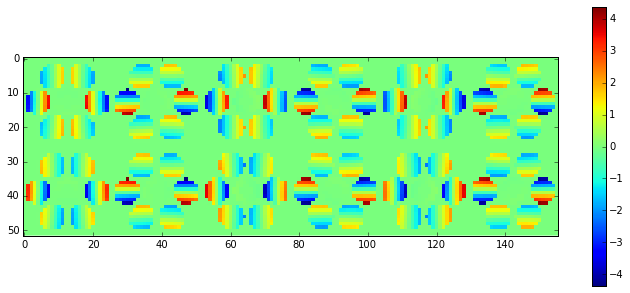

In [19]:
amp = 50*ceo.constants.MAS2RAD
M1_global_TT(amp,0)
sp = M2_seg_TT()
fig, ax2 = subplots()
fig.set_size_inches(12,5)
cp = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
M1_global_TT(-amp,0)
sm = M2_seg_TT()
cm = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
h2=ax2.imshow(np.concatenate((cp,cm),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)
D1gtt_2 = np.zeros((wfs.n_valid_slopes,2))
D1gtt_2[:,0] = ((sp-sm)/2)/amp

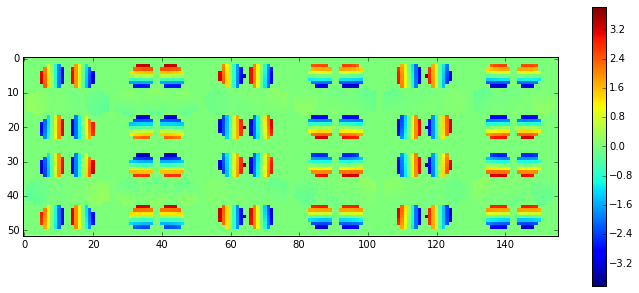

In [20]:
M1_global_TT(0,amp)
sp = M2_seg_TT()
cp = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
fig, ax2 = subplots()
fig.set_size_inches(12,5)
M1_global_TT(0,-amp)
sm = M2_seg_TT()
cm = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
h2=ax2.imshow(np.concatenate((cp,cm),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)
D1gtt_2[:,1] = ((sp-sm)/2)/amp

M1 global tip-tilt interaction matrix condition #:   1.00


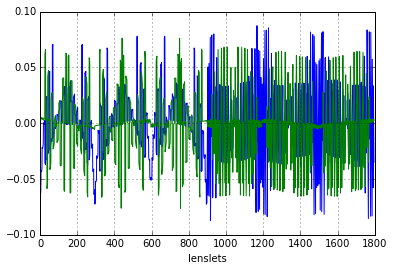

In [21]:
plot(D1gtt_2)
grid()
xlabel('lenslets')
print "M1 global tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D1gtt_2)

## M1 bending modes

In [22]:
mic2m = 1e-6
def M1_zern(zmode,zstroke,segId):
    gmt.reset()
    gmt.M1.zernike.a[segId,zmode] = zstroke
    gmt.M1.zernike.update()
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [23]:
zStroke = 1e-7
l = -1
zmodes = [4,5]
zmodes.extend(range(8,15))
nZernCoefs = len(zmodes)
D1z_2 = np.zeros((wfs.n_valid_slopes,7*nZernCoefs))
ps_z = np.zeros(shape=gs.phase.shape)
for kSeg in range(7):
    sys.stdout.write("Segment #%d: "%kSeg)
    for kMode in zmodes:
        sys.stdout.write("%d "%(kMode+1))
        M1_zern(kMode,zStroke,kSeg)
        sp = M2_seg_TT()
        M1_zern(kMode,-zStroke,kSeg)
        sm = M2_seg_TT()
        l += 1
        D1z_2[:,l] = ((sp-sm)/2)/(zStroke)   
    #ps_z = ps_z + gs.phase.host(units='micron') - ps0
    sys.stdout.write("\n")

Segment #0: 5 6 9 10 11 12 13 14 15 
Segment #1: 5 6 9 10 11 12 13 14 15 
Segment #2: 5 6 9 10 11 12 13 14 15 
Segment #3: 5 6 9 10 11 12 13 14 15 
Segment #4: 5 6 9 10 11 12 13 14 15 
Segment #5: 5 6 9 10 11 12 13 14 15 
Segment #6: 5 6 9 10 11 12 13 14 15 


Zernike modes interaction matrix condition #:   2.82


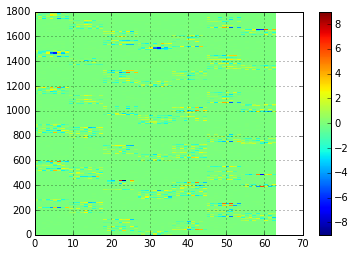

In [24]:
fig, ax = subplots()
h = ax.pcolor(D1z_2)
colorbar(h)
grid()
print "Zernike modes interaction matrix condition #: %6.2f"%np.linalg.cond(D1z_2)

# AGWS closed-loop control

## Resetting

In [42]:
gs.reset()
wfs.reset()
gmt.reset()
ps0 = gs.phase.host(units='nm').T
com1 = np.zeros((23+7*nZernCoefs,1))
com2xyz0 = np.zeros((21,1))
com1[2:23] = com2xyz0
com2xyz = com1[2:23]
com2 = np.zeros((14,1))
com10  = np.zeros((2,1))
com20  = np.zeros((14,1))
zern_coefs0 = np.zeros((7,nZernCoefs))
M1_STT  = np.zeros((7,2))
M2 = np.linalg.pinv( D2tt )
D12 = np.concatenate( (D1gtt_2, D2xyz_2, D1z_2) , axis=1)
M12 = np.linalg.pinv( D12 )

## Initial conditions

In [43]:
%run GMT-DOS-Estimation-SAO.py

### M1 global tip-tilt

In [44]:
com10 = (np.random.rand(2,1)*2-1)*M1_init['global tip-tilt [arcsec]']*ceo.constants.ARCSEC2RAD
print array_str(com10[:2]*ceo.constants.RAD2ARCSEC)
gmt.M1.global_tiptilt(com10[0],com10[1])
M1_O_GT = gmt.M1.motion_CS.origin
M1_A_GT = gmt.M1.motion_CS.euler_angles

[[-0.3687371 ]
 [-0.32973167]]


### M1 segment tip-tilts

In [45]:
M1_STT[:,0] = (2*np.random.rand(7)-1)*M1_init["Rx [arcsec]"]*ceo.constants.ARCSEC2RAD
M1_STT[:,1] = (2*np.random.rand(7)-1)*M1_init["Ry [arcsec]"]*ceo.constants.ARCSEC2RAD
#com20[:,2] = (2*np.random.rand(7)-1)*M2_init["Rz [arcsec]"]*ceo.constants.ARCSEC2RAD
print array_str(M1_STT*ceo.constants.RAD2ARCSEC,precision=2)

[[ 0.17  0.09]
 [ 0.2   0.  ]
 [-0.3  -0.35]
 [ 0.14 -0.24]
 [-0.12  0.29]
 [ 0.15 -0.04]
 [ 0.35 -0.41]]


### M1 bending modes (Zernike polynomials)

9


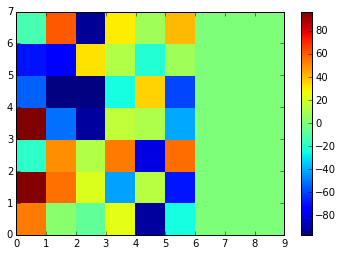

In [27]:
zern_coefs0 = (2*np.random.rand(7,nZernCoefs)-1)*M1_init['bending modes [micron]']*1e-6
zern_coefs0[:,6:] = 0
pcolor(zern_coefs0*1e9)
colorbar()
print nZernCoefs

### M2 x,y and z translations

In [46]:
com2xyz0 = np.zeros((7,3))
com2xyz0[:,0] = (2*np.random.rand(7)-1)*M2_init["Tx [micron]"]*1e-6
com2xyz0[:,1] = (2*np.random.rand(7)-1)*M2_init["Ty [micron]"]*1e-6
com2xyz0[:,2] = (2*np.random.rand(7)-1)*M2_init["Tz [micron]"]*1e-6
#com2xyz0 = (2*np.random.rand(21,1)-1)*50e-6
print array_str(com2xyz0*1e6,precision=2)
com2xyz0 = np.reshape(com2xyz0,(21,1))

[[ 79.17  24.01  -0.54]
 [ 16.05  61.4   -0.61]
 [ 41.12 -88.2    0.11]
 [ 11.98  23.1    0.94]
 [ 58.19  -5.38  -0.55]
 [ 38.21  65.41   0.94]
 [-54.9  -91.35   0.62]]


### M2 segment tip-tilts

In [29]:
com20 = np.reshape(com20,(7,2))
com20[:,0] = (2*np.random.rand(7)-1)*M2_init["Rx [arcsec]"]*ceo.constants.ARCSEC2RAD
com20[:,1] = (2*np.random.rand(7)-1)*M2_init["Ry [arcsec]"]*ceo.constants.ARCSEC2RAD
#com20[:,2] = (2*np.random.rand(7)-1)*M2_init["Rz [arcsec]"]*ceo.constants.ARCSEC2RAD
print array_str(com20*ceo.constants.RAD2MAS,precision=2)
com20 = np.reshape(com20,(14,1))

[[ 24.66  99.22]
 [-82.46  76.66]
 [-41.89 -35.39]
 [  0.43 -54.79]
 [-79.11 -73.52]
 [-82.57  49.21]
 [ 86.49  21.35]]


### Noise condition

In [29]:
ron = 0
gs.magnitude = AGWS_magnitude
print gs.nPhoton*30*368*1e-10

3600143.77334


## Initial on-axis PSF and wavefront

3118197.58176
2900619.263
(18, 18)
Initial WFE rms: 24461.80nm
66.6666666667


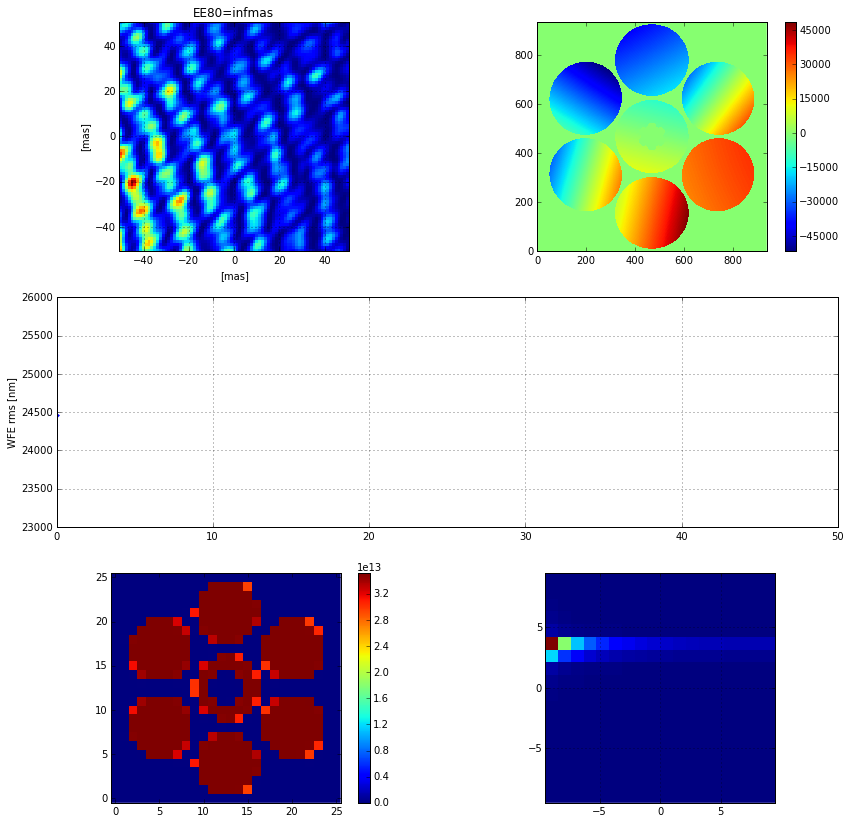

In [40]:
from IPython.display import display, clear_output

gmt.reset()
com1[:2] = np.array( com10 )
gmt.M1.global_tiptilt(com1[0],com1[1])
com1[2:23] = np.array( com2xyz0 )
com2xyz = com1[2:23]
#com1[23:] = np.random.randn(14,1)*1e-7
gmt.M1.zernike.a[:,zmodes] = zern_coefs0
gmt.M1.zernike.update()
com2 = np.array( com20 )
M1_O_GT = gmt.M1.motion_CS.origin
M1_A_GT = gmt.M1.motion_CS.euler_angles
M1_A_GT[:,:2] += M1_STT
for k in range(7):
    gmt.M1.update(origin=[M1_O_GT[k,0],M1_O_GT[k,1],M1_O_GT[k,2]],
                  euler_angles=[M1_A_GT[k,0],M1_A_GT[k,1],M1_A_GT[k,2]],idx=k+1)
    gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                  euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)
    
gs.reset()
wfs.reset()

src.reset()
gmt.propagate(src)
imgr.reset()
imgr.propagate(src)

fig = figure()
fig.set_size_inches((14,14))
ax1 = plt.subplot2grid((3,2),(0,0))
ax2 = plt.subplot2grid((3,2),(0,1))
ax  = plt.subplot2grid((3,2),(1,0), colspan=2)
ax3 = plt.subplot2grid((3,2),(2,0))
ax4 = plt.subplot2grid((3,2),(2,1))

psf = imgr.frame.host()

h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
ax1.set_title("EE80=%.2fmas"%ee80(psf,px_scale))

h2 = ax2.imshow(src.phase.host(units='nm'),interpolation='none',origin='lower')
colorbar(h2,ax=ax2)

gmt.propagate(gs)
wfs.propagate(gs)
wfs.readOut(30,ron)

h3 = ax3.imshow(wfs.flux.host()[:N_LENSLET,:],interpolation='none',origin='lower')
colorbar(h3,ax=ax3)
print wfs.flux.host().sum()*1e-10

frame = wfs.frame.host()
a = 5*18
print frame.sum()*1e-10
framelet = frame[a:a+18,a:a+18]
print framelet.shape
h4 = ax4.imshow(framelet,interpolation='none',origin='lower',extent=(-9.5,9.5,-9.5,9.5))
ax4.grid()

n1Step = 50
wfe_rms = np.zeros(n1Step+1)
wfe_rms[0] = src.wavefront.rms(-9)
h, = ax.plot(wfe_rms[:1],'.-')
ax.grid()
ax.set_ylabel("WFE rms [nm]")
ax.set_xlim((0,n1Step))
ax.set_autoscaley_on(True)
print "Initial WFE rms: %6.2fnm"%wfe_rms[0]
print 400./6

## Closing the loop

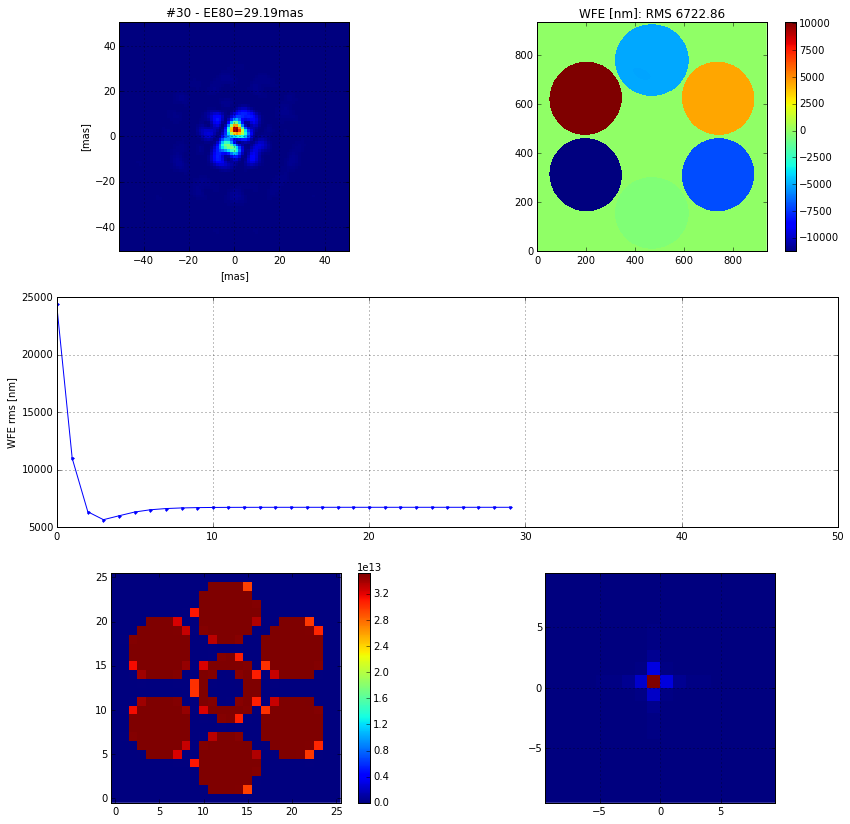

In [41]:
g1 = 0.5
g2 = 0.5
k1Step = 0
closed_loop = True
while closed_loop:
    
    %run GMT-DOS-Estimation-SAO.py
    
    ron = read_out_noise
    gs.magnitude = AGWS_magnitude

    for k2Step in range(10):
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
        com2 -= g2*np.dot(M2,wfs.valid_slopes.host().T)
        for k in range(7):
            gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                          euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)

    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.propagate(gs)
    wfs.readOut(30,ron)
    wfs.process()
    #wfs.analyze(gs)

    com1 -= g1*np.dot(M12,wfs.valid_slopes.host().T)
    com2xyz = com1[2:23]
    gmt.M1.global_tiptilt(com1[0],com1[1])
    gmt.M1.zernike.a[:,zmodes] = com1[23:].reshape(7,-1)
    gmt.M1.zernike.update()
    M1_O_GT = gmt.M1.motion_CS.origin
    M1_A_GT = gmt.M1.motion_CS.euler_angles
    M1_A_GT[:,:2] += M1_STT
    for k in range(7):
        gmt.M1.update(origin=[M1_O_GT[k,0],M1_O_GT[k,1],M1_O_GT[k,2]],
                  euler_angles=[M1_A_GT[k,0],M1_A_GT[k,1],M1_A_GT[k,2]],idx=k+1)
        gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                     euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)

    src.reset()
    gmt.propagate(src)
    imgr.reset()
    imgr.propagate(src)

    wfe = src.phase.host(units='nm')
    k1Step += 1
    idx = k1Step%(n1Step+1)
    wfe_rms[idx] = 1e9*src.wavefront.rms()
    
    ax.relim()
    ax.autoscale_view(scaley=True)
    
    if k1Step<n1Step:
        h.set_data(arange(idx),wfe_rms[:idx])
    else:
        h.set_data(arange(n1Step+1),np.roll(wfe_rms,-idx-1))
    
    psf = imgr.frame.host()
    h1.set_data(psf)
    h1.set_clim((psf.min(),psf.max()))
    ax1.set_title("#%d - EE80=%.2fmas"%(k1Step,ee80(psf,px_scale)))

    h2.set_data(wfe)
    h2.set_clim((wfe.min(),wfe.max()))
    ax2.set_title( "WFE [nm]: RMS %4.2f"%wfe_rms[idx])
    
    
    plt.hold(False)
    flux = wfs.flux.host()[:N_LENSLET,:]
    h3.set_data(flux)
    h3.set_clim((flux.min(),flux.max()))
        
    frame = wfs.frame.host()
    framelet = frame[a:a+18,a:a+18]
    h4.set_data(framelet)
    h4.set_clim((framelet.min(),framelet.max()))


    clear_output(wait=True)
    display(fig)
plt.close()

## Wavefront error rms

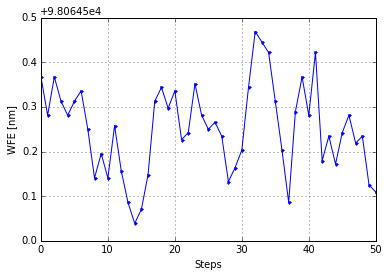

In [33]:
plot(wfe_rms,'.-')
grid()
xlabel('Steps')
ylabel('WFE [nm]')

<matplotlib.colorbar.Colorbar instance at 0x2b4a67331c68>

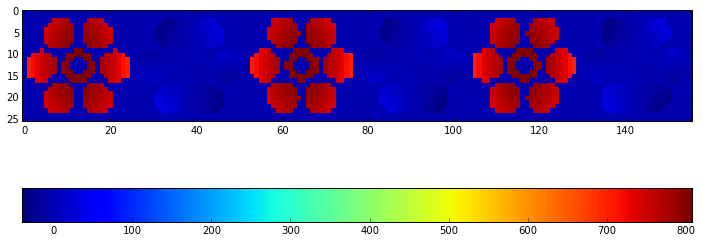

In [31]:
wfs.reset()
wfs.analyze(gs)
fig = figure()
fig.set_size_inches((12,8))
imshow(wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(orientation='horizontal')